In [81]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

# GP t-distribution

In [14]:
train_x = torch.linspace(0, 1, 10)
train_y = torch.sin(2 * math.pi * train_x)

Epoch 100/500  −  Loss: 0.938
Epoch 200/500  −  Loss: 0.886
Epoch 300/500  −  Loss: 0.884
Epoch 400/500  −  Loss: 0.884
Epoch 500/500  −  Loss: 0.884
mean: torch.Size([10, 200])


ValueError: x and y must have same first dimension, but have shapes (200,) and (10, 200)

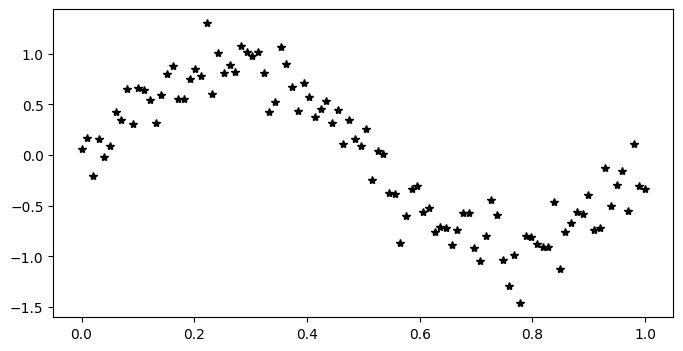

In [35]:
import torch
import gpytorch
from matplotlib import pyplot as plt

# ---- 1.  Fake training data --------------------------------------------------
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * torch.pi)) + 0.2 * torch.randn_like(train_x)

# ---- 2.  Model definition ----------------------------------------------------
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # 2a. Variational objects
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)

        # 2b. Mean & covariance modules
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ---- 3.  Likelihood & model instances ---------------------------------------
likelihood = gpytorch.likelihoods.StudentTLikelihood()   # ν = degrees of freedom
inducing_points = train_x[::5]  # pick 20 inducing points, shape (20, 1)
model = GPModel(inducing_points)

# ---- 4.  Training setup ------------------------------------------------------
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

num_epochs = 500
for i in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if (i + 1) % 100 == 0:
        print(f"Epoch {i+1}/{num_epochs}  −  Loss: {loss.item():.3f}")
    optimizer.step()

# ---- 5.  Evaluation & plotting ----------------------------------------------
model.eval()
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 1, 200)
    pred_dist = likelihood(model(test_x))
    mean = pred_dist.loc
    std = pred_dist.scale * torch.sqrt((pred_dist.df)/(pred_dist.df - 2))

print("mean:", mean.shape)

plt.figure(figsize=(8, 4))
plt.plot(train_x.numpy(), train_y.numpy(), "k*", label="Train datapoints")
plt.plot(test_x.numpy(), mean.numpy(), label="Predictive mean")
plt.fill_between(mean.numpy(),
                 mean.numpy() + 2*std.numpy(),
                 mean.numpy() - 2*std.numpy(),
                 alpha=0.3,
                 label="95% cred. band")
plt.legend(); plt.title("Approximate GP with Student‑T likelihood")
plt.show()


Epoch 100/500  −  Loss: 0.953
Epoch 200/500  −  Loss: 0.890
Epoch 300/500  −  Loss: 0.887
Epoch 400/500  −  Loss: 0.887
Epoch 500/500  −  Loss: 0.887
StudentT(df: torch.Size([10, 200]), loc: torch.Size([10, 200]), scale: torch.Size([10, 200]))
mean: tensor([[ 0.5744,  0.5882,  0.5862,  ..., -0.1884, -0.2035, -0.1670],
        [ 0.0456,  0.0637,  0.0683,  ..., -0.1069, -0.0417, -0.0509],
        [ 0.2241,  0.2306,  0.2528,  ..., -0.3995, -0.3912, -0.3601],
        ...,
        [ 0.4993,  0.5063,  0.5094,  ..., -0.4458, -0.4415, -0.4284],
        [-0.0526, -0.0447, -0.0140,  ...,  0.1553,  0.2011,  0.2034],
        [ 0.1163,  0.1651,  0.2242,  ..., -0.2380, -0.2495, -0.2748]])


ValueError: 'x' is not 1-dimensional

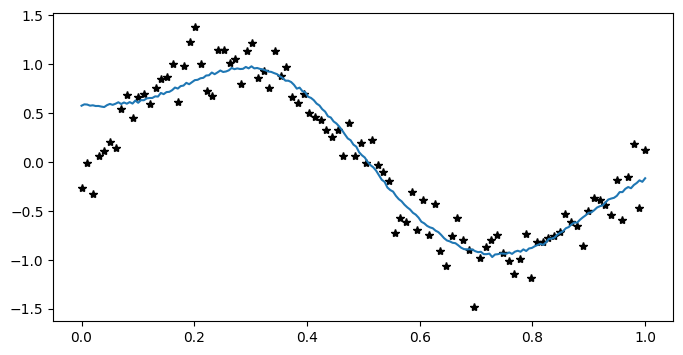

In [43]:
import torch
import gpytorch
from matplotlib import pyplot as plt

# ---- 1.  Fake training data --------------------------------------------------
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * torch.pi)) + 0.2 * torch.randn_like(train_x)

# ---- 2.  Model definition ----------------------------------------------------
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # 2a. Variational objects
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)

        # 2b. Mean & covariance modules
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ---- 3.  Likelihood & model instances ---------------------------------------
likelihood = gpytorch.likelihoods.StudentTLikelihood()  # ν = degrees of freedom
inducing_points = train_x[::5]  # pick 20 inducing points, shape (20, 1)
model = GPModel(inducing_points)

# ---- 4.  Training setup ------------------------------------------------------
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

num_epochs = 500
for i in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if (i + 1) % 100 == 0:
        print(f"Epoch {i+1}/{num_epochs}  −  Loss: {loss.item():.3f}")
    optimizer.step()

# ---- 5.  Evaluation & plotting ----------------------------------------------
model.eval()
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 1, 200)
    f_preds = model(test_x)
    pred_dist = likelihood(f_preds)
    print(pred_dist)
    mean = pred_dist.loc
    std = pred_dist.scale * torch.sqrt((pred_dist.df)/(pred_dist.df - 2))

print("mean:", mean)

plt.figure(figsize=(8, 4))
plt.plot(train_x.numpy(), train_y.numpy(), "k*", label="Train datapoints")
plt.plot(test_x.numpy(), mean[0].numpy(), label="Predictive mean")
plt.fill_between(mean.numpy(),
                 mean.numpy() + 2*std.numpy(),
                 mean.numpy() - 2*std.numpy(),
                 alpha=0.3,
                 label="95% cred. band")
plt.legend(); plt.title("Approximate GP with Student‑T likelihood")
plt.show()


# GP Classification example

In [ ]:
train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

In [84]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [50]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.908
Iter 2/50 - Loss: 5.393
Iter 3/50 - Loss: 8.486
Iter 4/50 - Loss: 3.704
Iter 5/50 - Loss: 6.678
Iter 6/50 - Loss: 6.995
Iter 7/50 - Loss: 6.298
Iter 8/50 - Loss: 4.970
Iter 9/50 - Loss: 3.932
Iter 10/50 - Loss: 3.237
Iter 11/50 - Loss: 2.857
Iter 12/50 - Loss: 2.643
Iter 13/50 - Loss: 2.398
Iter 14/50 - Loss: 2.207
Iter 15/50 - Loss: 1.926
Iter 16/50 - Loss: 1.665
Iter 17/50 - Loss: 1.543
Iter 18/50 - Loss: 1.504
Iter 19/50 - Loss: 1.473
Iter 20/50 - Loss: 1.452
Iter 21/50 - Loss: 1.444
Iter 22/50 - Loss: 1.442
Iter 23/50 - Loss: 1.437
Iter 24/50 - Loss: 1.427
Iter 25/50 - Loss: 1.411
Iter 26/50 - Loss: 1.390
Iter 27/50 - Loss: 1.364
Iter 28/50 - Loss: 1.335
Iter 29/50 - Loss: 1.304
Iter 30/50 - Loss: 1.271
Iter 31/50 - Loss: 1.238
Iter 32/50 - Loss: 1.207
Iter 33/50 - Loss: 1.177
Iter 34/50 - Loss: 1.151
Iter 35/50 - Loss: 1.128
Iter 36/50 - Loss: 1.109
Iter 37/50 - Loss: 1.093
Iter 38/50 - Loss: 1.078
Iter 39/50 - Loss: 1.063
Iter 40/50 - Loss: 1.047
Iter 41/5

In [51]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

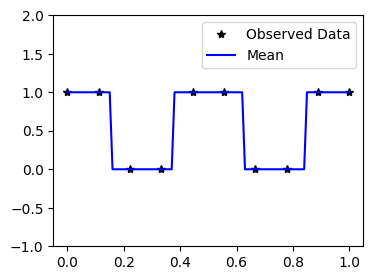

In [ ]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 100)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])

## Trying the same for student-t

In [85]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * torch.pi)) + 0.2 * torch.randn_like(train_x)
test_x = torch.linspace(0, 1, 200)

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy

class StudentTModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(StudentTModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.StudentTLikelihood()

In [86]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(50):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.590
Iter 2/50 - Loss: 14.530
Iter 3/50 - Loss: 68.797
Iter 4/50 - Loss: 18.281
Iter 5/50 - Loss: 37.748
Iter 6/50 - Loss: 37.332
Iter 7/50 - Loss: 19.791
Iter 8/50 - Loss: 12.692
Iter 9/50 - Loss: 14.875
Iter 10/50 - Loss: 17.761
Iter 11/50 - Loss: 15.842
Iter 12/50 - Loss: 12.920
Iter 13/50 - Loss: 11.656
Iter 14/50 - Loss: 11.470
Iter 15/50 - Loss: 11.103
Iter 16/50 - Loss: 9.469
Iter 17/50 - Loss: 8.331
Iter 18/50 - Loss: 7.835
Iter 19/50 - Loss: 8.010
Iter 20/50 - Loss: 7.814
Iter 21/50 - Loss: 7.298
Iter 22/50 - Loss: 6.862
Iter 23/50 - Loss: 6.616
Iter 24/50 - Loss: 6.687
Iter 25/50 - Loss: 6.379
Iter 26/50 - Loss: 6.126
Iter 27/50 - Loss: 5.892
Iter 28/50 - Loss: 5.803
Iter 29/50 - Loss: 5.735
Iter 30/50 - Loss: 5.556
Iter 31/50 - Loss: 5.245
Iter 32/50 - Loss: 4.910
Iter 33/50 - Loss: 4.659
Iter 34/50 - Loss: 4.464
Iter 35/50 - Loss: 4.251
Iter 36/50 - Loss: 4.024
Iter 37/50 - Loss: 3.801
Iter 38/50 - Loss: 3.598
Iter 39/50 - Loss: 3.434
Iter 40/50 - Loss: 3

In [87]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))
print(y_preds)

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

StudentT(df: torch.Size([10, 200]), loc: torch.Size([10, 200]), scale: torch.Size([10, 200]))


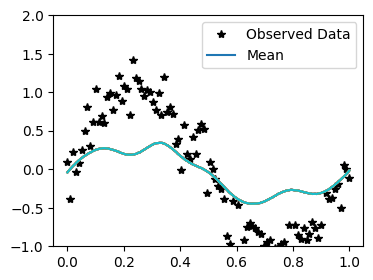

In [88]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 200)
    observed_pred = likelihood(f_preds)

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_y = observed_pred.mean.float()
    for i in range(10):
        ax.plot(test_x.numpy(), np.mean(pred_y.numpy(), axis=0))
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])